# Livestock Mortality Index

This notebook will attempt to replicate and expand on a model to forecast the risk of livestock mortality in aimags (provinces) of Mongolia. The index is based on work completed by the People in Need NGO and the English report is available in this repository.

## Data import

The data used in the model is stored in a PDF file as tables. These tables were copied into an Excel spreadsheet and several cleaning and transformation steps took place. The original data copied from the PDF report is in **data/DATASET for MVDI report.xlsx** and the cleaned data is stored at **data/MVDI Tables Cleaned.xlsx**.

In [1]:
#Import required libraries
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics import mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

In [2]:
xls = pd.ExcelFile('data/MVDI Tables Cleaned.xlsx')

In [3]:
sheets = xls.sheet_names
sheets

['temp',
 'loss',
 'index',
 'pasture_anomaly',
 'pasture',
 'biomass_anomaly',
 'biomass',
 'zootechnical',
 'mortality',
 'fecundity',
 'snowfall_anomaly']

In [4]:
temp = xls.parse('temp')
loss = xls.parse('loss')
index = xls.parse('index')
pasture_anomaly = xls.parse('pasture_anomaly')
pasture = xls.parse('pasture')
biomass_anomaly = xls.parse('biomass_anomaly')
biomass = xls.parse('biomass')
zootechnical = xls.parse('zootechnical')
mortality = xls.parse('mortality')
fecundity = xls.parse('fecundity')
snowfall_anomaly = xls.parse('snowfall_anomaly')

In [5]:
dfs = [temp,loss, index, pasture_anomaly, pasture, biomass_anomaly, biomass, zootechnical, mortality,fecundity,snowfall_anomaly]

In [6]:
from functools import reduce
df = reduce(lambda  left,right: pd.merge(left,right,on=['Aimag','Year'], how='inner'), dfs)

In [7]:
df['Aimag'].unique()

array(['Arkhangai', 'Bayankhongor', 'Bayan‐Ulgii', 'Bulgan', 'Dornod',
       'Dornogovi', 'Dundgovi', 'Govisumber', 'Khentii', 'Khovd',
       'Khuvsgul', 'Orkhon', 'Selenge', 'Sukhbaatar', 'Tuv',
       'Ulaanbaatar', 'Umnugovi', 'Uvs', 'Uvurkhangai', 'Zavkhan'],
      dtype=object)

In [8]:
df.head()

,Aimag,Year,Temprature anomalies,Livestock Loss Rates from - 1998-2017,Past values of the vulnerability index according to Aimag - 1: Average weighed by livestock numbers in SFU,Pasture Use Anomaly,Pasture Use,Standing forage biomass anomaly,Standing forage biomass (tons),Zootechnical score,Mortality score,Fecundity score,Snowfall anomalies
0,Arkhangai,1999,2.75,0.01,1.69,0.04,0.11,0.05,2.96E+ 07,0,0,0,-3.80
1,Arkhangai,2000,-0.39,0.06,1.94,0.18,0.12,-0.13,2.44E+ 07,0,0,0,4.57
2,Arkhangai,2001,-1.62,0.24,2.63,-0.02,0.10,-0.22,2.20E+ 07,2,1,1,8.10
3,Arkhangai,2002,0.86,0.04,2.81,0.63,0.17,-0.57,1.22E+ 07,0,0,0,5.44
4,Arkhangai,2003,-0.10,0.07,1.15,-0.25,0.08,-0.07,2.61E+ 07,0,0,0,9.70


## Data Cleaning

Now that we have all of our features in one dataframe we can start cleaning the dataset so it is in a better format. 

To do:
- Rename features to be more simple and allow for easier reference
- Standing forage biomass was stored in the original report as scientific notation. This is now stored as text. 
- 

### Rename Columns

In [9]:
df.columns

Index(['Aimag', 'Year', 'Temprature anomalies',
       'Livestock Loss Rates from - 1998-2017',
       'Past values of the vulnerability index according to Aimag - 1: Average weighed by livestock numbers in SFU',
       'Pasture Use Anomaly', 'Pasture Use', 'Standing forage biomass anomaly',
       'Standing forage biomass (tons)', 'Zootechnical score',
       'Mortality score', 'Fecundity score', 'Snowfall anomalies'],
      dtype='object')

In [10]:
df.rename(index=str,columns={'Aimag':'aimag', 'Year':'year', 'Temprature anomalies':'temperature_anomaly',
       'Livestock Loss Rates from - 1998-2017':'livestock_loss',
       'Past values of the vulnerability index according to Aimag - 1: Average weighed by livestock numbers in SFU':'index',
       'Pasture Use Anomaly':'pasture_use_anomaly', 'Pasture Use':'pasture_use', 'Standing forage biomass anomaly':'biomass_anomaly',
       'Standing forage biomass (tons)':'biomass', 'Zootechnical score':'zootechnical',
       'Mortality score':'mortality', 'Fecundity score':'fecundity', 'Snowfall anomalies':'snowfall_anomaly'},inplace=True)

### Convert biomass to numeric feature

The biomass feature is stored in the format '2.96E+ 07' (scientific notation). We do not have access to the complete number, so we will concatenate the number and take the left three characters. 

In [11]:
df['biomass'] = df['biomass'].str[:4]

In [12]:
df['biomass'] = pd.to_numeric(df['biomass'])

In [13]:
df.head()

,aimag,year,temperature_anomaly,livestock_loss,index,pasture_use_anomaly,pasture_use,biomass_anomaly,biomass,zootechnical,mortality,fecundity,snowfall_anomaly
0,Arkhangai,1999,2.75,0.01,1.69,0.04,0.11,0.05,2.96,0,0,0,-3.80
1,Arkhangai,2000,-0.39,0.06,1.94,0.18,0.12,-0.13,2.44,0,0,0,4.57
2,Arkhangai,2001,-1.62,0.24,2.63,-0.02,0.10,-0.22,2.20,2,1,1,8.10
3,Arkhangai,2002,0.86,0.04,2.81,0.63,0.17,-0.57,1.22,0,0,0,5.44
4,Arkhangai,2003,-0.10,0.07,1.15,-0.25,0.08,-0.07,2.61,0,0,0,9.70


In [14]:
np.average(df['livestock_loss']) + np.std(df['livestock_loss'])

0.12766390562390334

In [15]:
df['livestock_loss'].describe()

count    320.000000
mean       0.049656
std        0.078130
min        0.000000
25%        0.010000
50%        0.020000
75%        0.050000
max        0.460000
Name: livestock_loss, dtype: float64

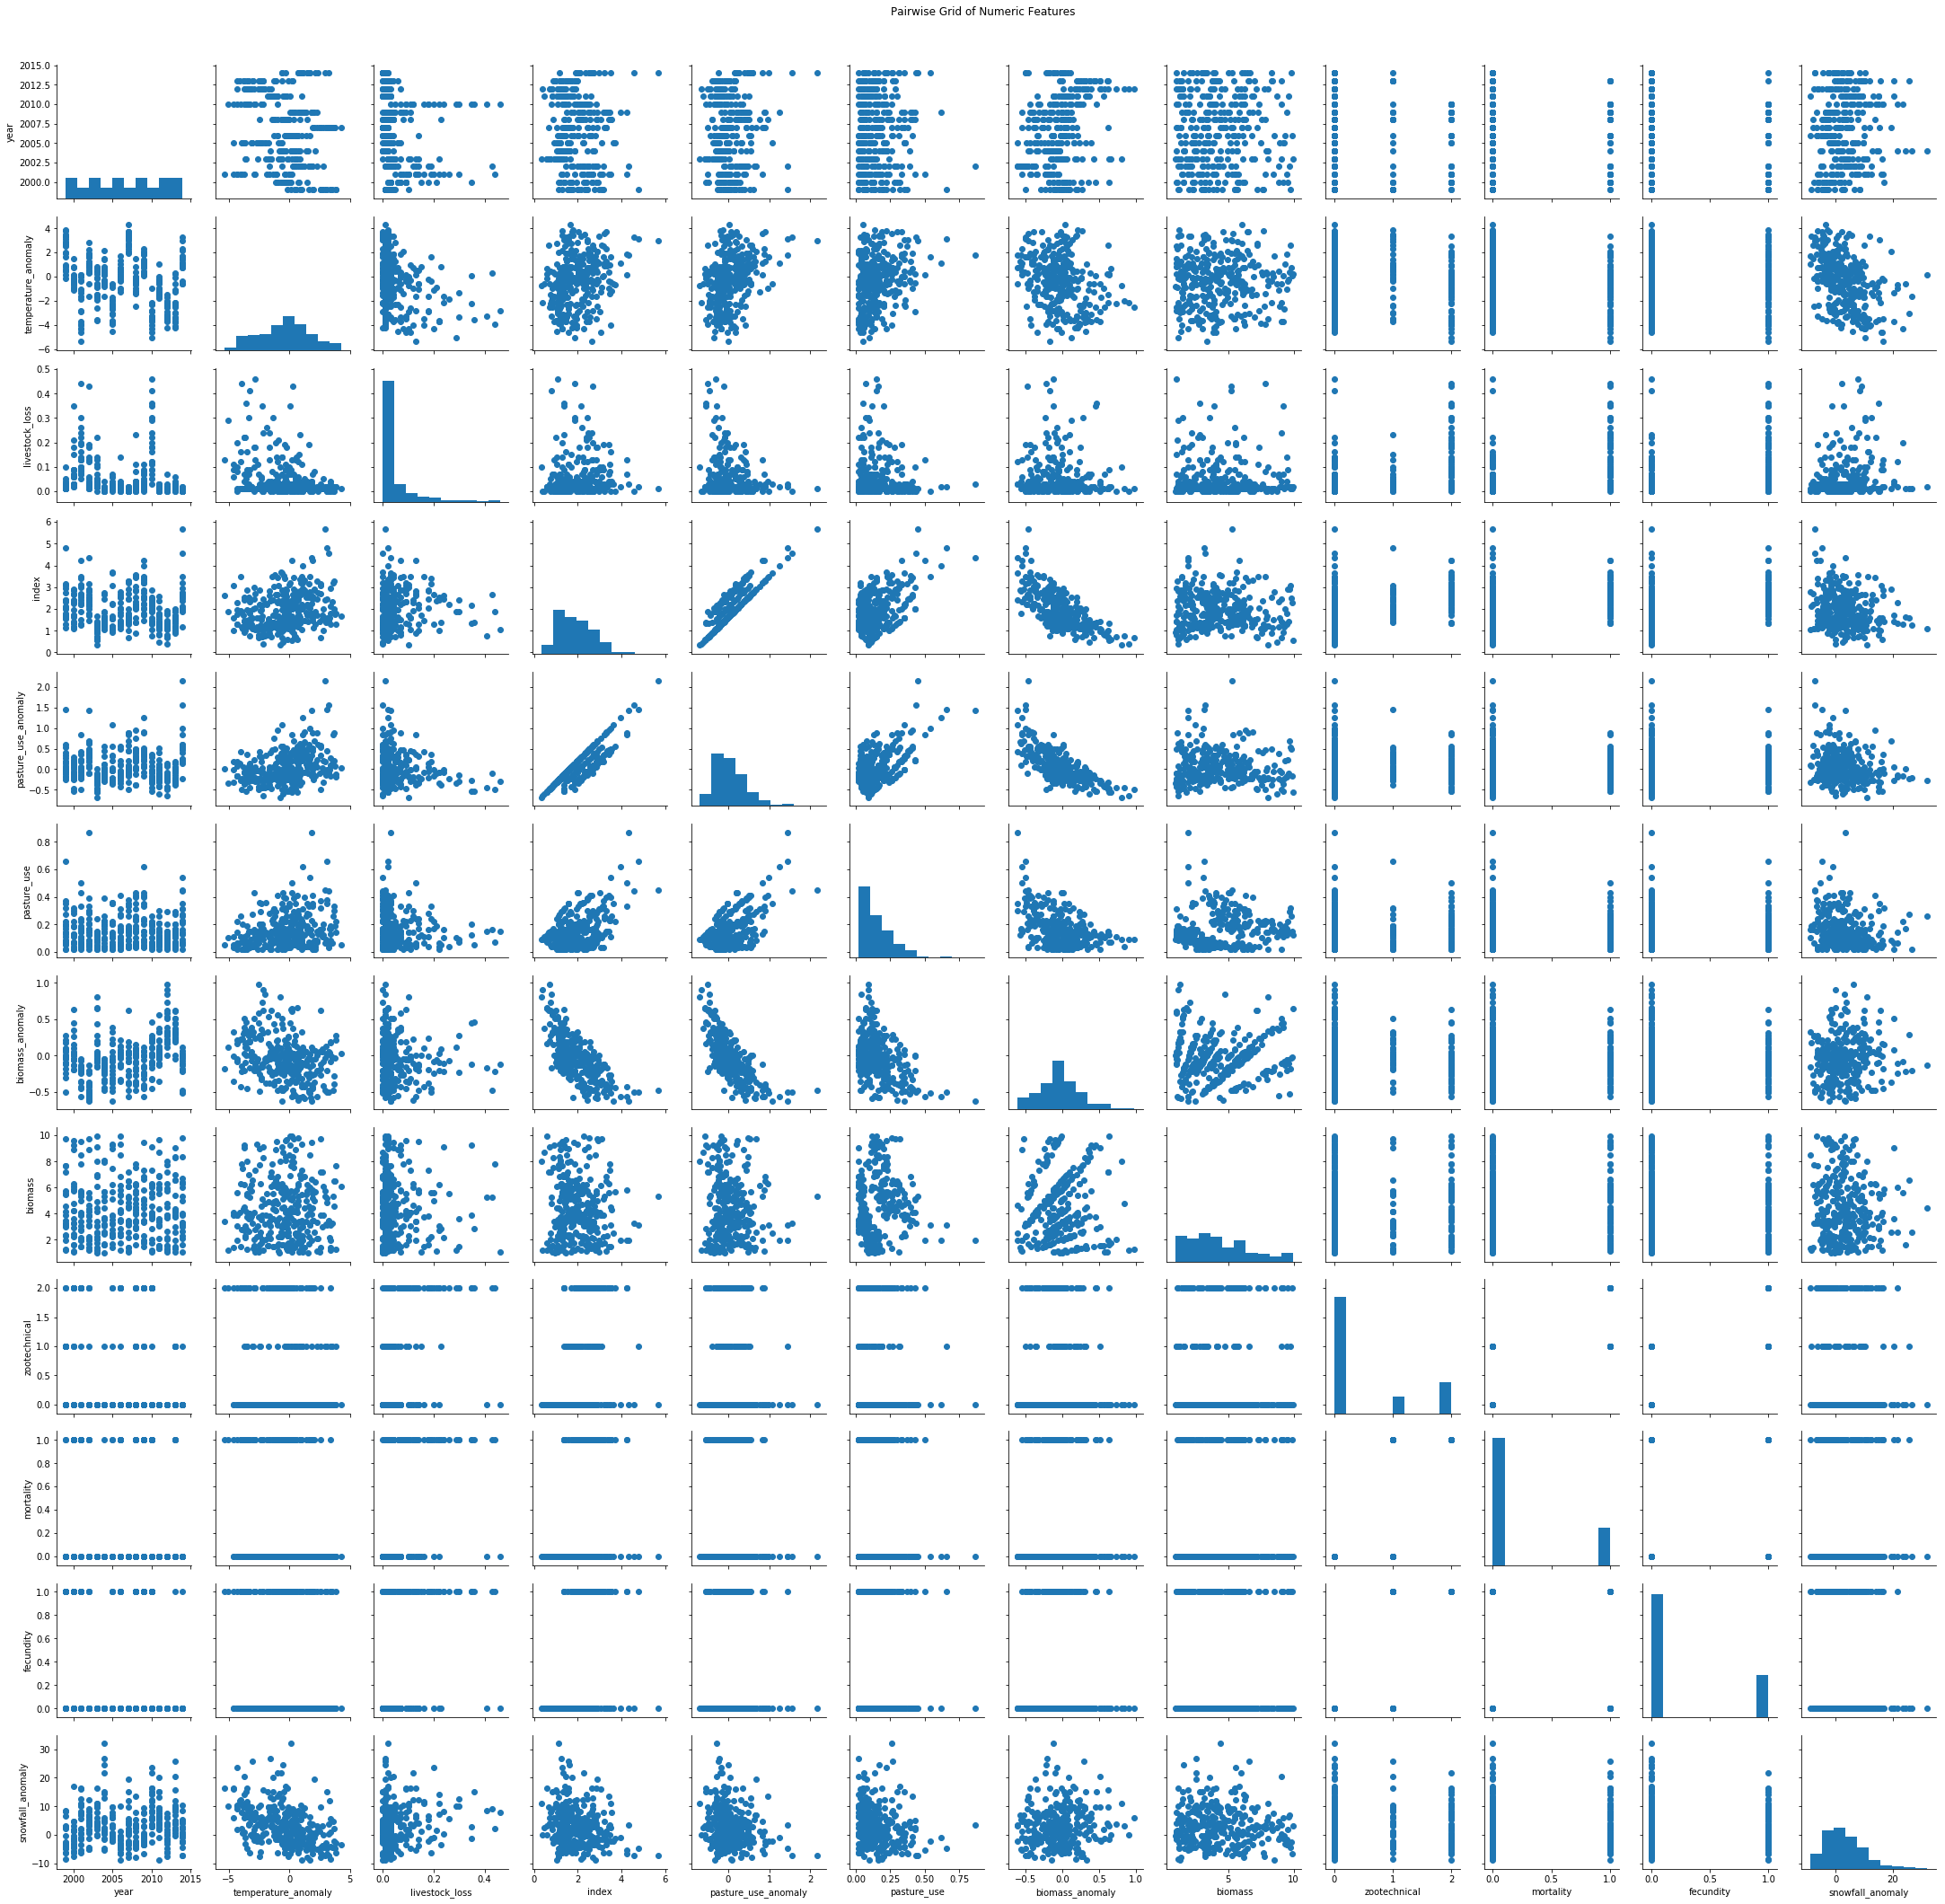

In [16]:
import seaborn as sns

# Pair grid of key variables.
g = sns.PairGrid(df)
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
plt.subplots_adjust(top=0.95)
g.fig.suptitle('Pairwise Grid of Numeric Features');

Text(0.5, 1.0, 'Correlation Heatmap of Numeric Features')

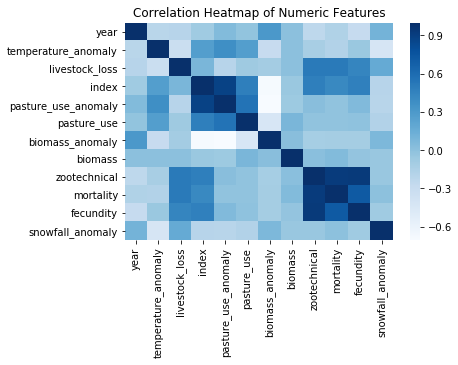

In [17]:
corr = df.corr()
sns.heatmap(corr, 
            xticklabels=corr.columns.values,
            yticklabels=corr.columns.values, cmap='Blues')
plt.title('Correlation Heatmap of Numeric Features')

## Confusion Matrix

As the MVDI research paper gives us mortality and the output risk scores, we can create an independent accuracy assessment. In addition, we can use the papers own classification methodology to create a confusion matrix that will allow us to assess false positives and negatives.

The classification methodology creates bins for the risk scores that correspond to a range of mortality. It is as follows:

Index value Mean mortality
- 0‐1     1%
- 1‐2     3%
- 2‐3     6%
- 3+      17%

As the bins for both the index and mean mortality don't say which boundary is inclusive or exclusive, we will need to do a little determination of our own. 

Index --- Mean Mortality
- 0-1  [0%-3%]
- 1-2  (3%-6%]
- 2-3  (6%-17%]
- 3+   (17%+)

The confusion matrix was created in Excel and is located in the 'data' directory.

## Recreating MVDI Index

Using the data in the MVDI report, I will attempt to recreate the index using the available data. Some key points:

- We do not have the dataframe or a flat file we can import to ensure we have the correct data format. Our data was copied from PDF tables and assembled into our dataframe here.
- The standing forage biomass data was written in scientific notation in the report, meaning we may have a loss of data with our truncated numbers.
- The original model was created in R using the geeglm package. This is a general linear model. We can somewhat replicate this via the Linear Regression. However the current scikit learn package does not support a poisson distribution in a GLM. Given this we can assume that a replicated model using scikit learn would have a lower performance.

Given our lack of ability to replicate the original model, we will attempt to instead use the same features and test multiple algorithms. In addition, we will later attempt to do some feature engineering to explore whether we can improve upon this base model futher. 


In [18]:
%%html
<img src="assets/features.PNG",width=500>

In [19]:
df.head()

,aimag,year,temperature_anomaly,livestock_loss,index,pasture_use_anomaly,pasture_use,biomass_anomaly,biomass,zootechnical,mortality,fecundity,snowfall_anomaly
0,Arkhangai,1999,2.75,0.01,1.69,0.04,0.11,0.05,2.96,0,0,0,-3.80
1,Arkhangai,2000,-0.39,0.06,1.94,0.18,0.12,-0.13,2.44,0,0,0,4.57
2,Arkhangai,2001,-1.62,0.24,2.63,-0.02,0.10,-0.22,2.20,2,1,1,8.10
3,Arkhangai,2002,0.86,0.04,2.81,0.63,0.17,-0.57,1.22,0,0,0,5.44
4,Arkhangai,2003,-0.10,0.07,1.15,-0.25,0.08,-0.07,2.61,0,0,0,9.70


Here we will shift the four N-1 features. We will also drop the original features and save our dataframe.

In [20]:
df = df.groupby('aimag')['biomass_anomaly','zootechnical','pasture_use_anomaly'].shift(1).merge(df,
                left_index=True,right_index=True,suffixes=('_1', '')).drop(columns=[
                'biomass_anomaly','zootechnical','pasture_use_anomaly'],axis=1)


In [21]:
df.head()

,biomass_anomaly_1,zootechnical_1,pasture_use_anomaly_1,aimag,year,temperature_anomaly,livestock_loss,index,pasture_use,biomass,mortality,fecundity,snowfall_anomaly
0,NaN,NaN,NaN,Arkhangai,1999,2.75,0.01,1.69,0.11,2.96,0,0,-3.80
1,0.05,0.0,0.04,Arkhangai,2000,-0.39,0.06,1.94,0.12,2.44,0,0,4.57
2,-0.13,0.0,0.18,Arkhangai,2001,-1.62,0.24,2.63,0.10,2.20,1,1,8.10
3,-0.22,2.0,-0.02,Arkhangai,2002,0.86,0.04,2.81,0.17,1.22,0,0,5.44
4,-0.57,0.0,0.63,Arkhangai,2003,-0.10,0.07,1.15,0.08,2.61,0,0,9.70


### Construct training dataframe.

Using the features from the report we can construct our dataframe. We have the 'index' values as created by the MVDI model. 

- The target variable is livestock_loss, which is expressed as a fraction of 1 (100%)

Here is the fit function as given by the report:
> gee.fit <- geeglm(Loss_rate_Y_100~Snowfall11_3_anomaly_Y*Forage_anomaly_Y_minus_1*Zootechnical_index_Y_minus_1+Temp11_2_anomaly_Y*Pasture_Use_Y_minus_1_anomaly*Zootechnical_index_Y_minus_1,
id=Aimag_code, waves= Year, data=Mortality_Mongolia_geepack, family=poisson, corstr=”exch”)

As such we can add the following features to our training dataframe:

- snowfall_anomaly (N)
- biomass_anomaly (N-1)
- zootechnical (N-1)
- temperature_anomaly (N)
- pasture_use_anomaly (N-1)
- livestock_loss (target variable)

In [22]:
df.columns

Index(['biomass_anomaly_1', 'zootechnical_1', 'pasture_use_anomaly_1', 'aimag',
       'year', 'temperature_anomaly', 'livestock_loss', 'index', 'pasture_use',
       'biomass', 'mortality', 'fecundity', 'snowfall_anomaly'],
      dtype='object')

In [23]:
train = df.drop(columns=[
    'aimag','year','fecundity','mortality',
    'biomass','pasture_use','index'], axis=1)

In [24]:
train.head()

,biomass_anomaly_1,zootechnical_1,pasture_use_anomaly_1,temperature_anomaly,livestock_loss,snowfall_anomaly
0,NaN,NaN,NaN,2.75,0.01,-3.80
1,0.05,0.0,0.04,-0.39,0.06,4.57
2,-0.13,0.0,0.18,-1.62,0.24,8.10
3,-0.22,2.0,-0.02,0.86,0.04,5.44
4,-0.57,0.0,0.63,-0.10,0.07,9.70


We will drop the NaN values as this row will not be able to be used in the training algorithm.

In [25]:
train = train.dropna(axis=0).reset_index(drop=True)

In [26]:
train.head()

,biomass_anomaly_1,zootechnical_1,pasture_use_anomaly_1,temperature_anomaly,livestock_loss,snowfall_anomaly
0,0.05,0.0,0.04,-0.39,0.06,4.57
1,-0.13,0.0,0.18,-1.62,0.24,8.10
2,-0.22,2.0,-0.02,0.86,0.04,5.44
3,-0.57,0.0,0.63,-0.10,0.07,9.70
4,-0.07,0.0,-0.25,0.54,0.01,2.30


In [27]:
train.shape

(300, 6)

## Train GLM Algorithms - Original Dataset

The model in the MVDI report is a GLM model (generalized linear model). A poisson distribution is specifically mentioned, so here we will attempt to use models that support this.

In [28]:
y = train['livestock_loss']
X = train.drop(columns=['livestock_loss'],axis=1)

In [29]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

#### Linear Regression

In [30]:
from sklearn.linear_model import LinearRegression

params = {"model_type": "Linear Regression"
          }

reg = LinearRegression()
reg.fit(X_train, y_train)

regr_pred = reg.predict(X_test)
regression_score = reg.score(X_test, y_test)
lin_rmse = np.sqrt((mean_squared_error(y_test, regr_pred)))

print("R^2: ", regression_score)
print("RMSE: ", lin_rmse)

R^2:  0.43973529695413777
RMSE:  0.06985463757468893


#### Ridge Regression

In [31]:
from sklearn.linear_model import Ridge

params = {"model_type": "Ridge Regression"
          }

ridge = Ridge(alpha=.5)
ridge.fit(X_train, y_train) 

ridge_pred = ridge.predict(X_test)
ridge_score = ridge.score(X_test, y_test)
ridge_rmse = np.sqrt((mean_squared_error(y_test, ridge_pred)))

print("R^2: ", ridge_score)
print("RMSE: ", ridge_rmse)

R^2:  0.43535875299914095
RMSE:  0.07012694383381707


#### XGBoost

In [32]:
from xgboost import XGBRegressor

params = {"model_type": "XGBRegressor",
          "random_state": 42,
          "n_estimators": 100
          }

xgb = XGBRegressor(random_state=params['random_state'], n_estimators=params['n_estimators'])
xgb.fit(X_train,y_train)

xgb_pred = xgb.predict(X_test)
xgb_score = xgb.score(X_test, y_test)
xgb_rmse = np.sqrt((mean_squared_error(y_test, xgb_pred)))

print("R^2: ", xgb_score)
print("RMSE: ", xgb_rmse)

R^2:  0.41344904539413185
RMSE:  0.07147455916648646


#### Random Forest Regressor

In [33]:
from sklearn.ensemble import RandomForestRegressor

params = {"model_type": "Random Forest",
          "random_state": 42,
          "n_estimators": 300
          }

rf = RandomForestRegressor(random_state=params['random_state'], n_estimators=params['n_estimators'])
rf.fit(X_train,y_train)

rf_pred = rf.predict(X_test)
rf_score = rf.score(X_test, y_test)
rf_rmse = np.sqrt((mean_squared_error(y_test, rf_pred)))

print("R^2: ", rf_score)
print("RMSE: ", rf_rmse)

R^2:  0.41124301181046596
RMSE:  0.07160884187422596


#### Extra Trees

In [34]:
from sklearn.ensemble import ExtraTreesRegressor

extra = ExtraTreesRegressor(random_state=42, 
                            n_estimators=100,
                           min_samples_split=5)
extra.fit(X_train,y_train)

extra_pred = extra.predict(X_test)
extra_score = extra.score(X_test, y_test)
extra_rmse = np.sqrt((mean_squared_error(y_test, extra_pred)))

print("R^2: ", extra_score)
print("RMSE: ", extra_rmse)

R^2:  0.4739248409938822
RMSE:  0.0676896876434779


#### AdaBoost

In [35]:
from sklearn.ensemble import AdaBoostRegressor

params = {"model_type": "AdaBoost",
          "random_state": 42,
          "n_estimators": 300
          }

ada = AdaBoostRegressor(random_state=params['random_state'], n_estimators=params['n_estimators'])
ada.fit(X_train,y_train)

ada_pred = ada.predict(X_test)
ada_score = ada.score(X_test, y_test)
ada_rmse = np.sqrt((mean_squared_error(y_test, ada_pred)))

print("R^2: ", ada_score)
print("RMSE: ", ada_rmse)

R^2:  0.2158599397185037
RMSE:  0.08264097518689711


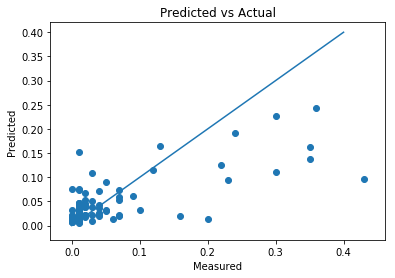

In [36]:
plt.scatter(y_test, extra_pred)
plt.plot(np.linspace(0, .4, 1000),np.linspace(0, .4, 1000))
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

## Expanded training set

In [37]:
df.head()

,biomass_anomaly_1,zootechnical_1,pasture_use_anomaly_1,aimag,year,temperature_anomaly,livestock_loss,index,pasture_use,biomass,mortality,fecundity,snowfall_anomaly
0,NaN,NaN,NaN,Arkhangai,1999,2.75,0.01,1.69,0.11,2.96,0,0,-3.80
1,0.05,0.0,0.04,Arkhangai,2000,-0.39,0.06,1.94,0.12,2.44,0,0,4.57
2,-0.13,0.0,0.18,Arkhangai,2001,-1.62,0.24,2.63,0.10,2.20,1,1,8.10
3,-0.22,2.0,-0.02,Arkhangai,2002,0.86,0.04,2.81,0.17,1.22,0,0,5.44
4,-0.57,0.0,0.63,Arkhangai,2003,-0.10,0.07,1.15,0.08,2.61,0,0,9.70


In [38]:
df = df.groupby('aimag')['biomass_anomaly_1','zootechnical_1','pasture_use_anomaly_1'].shift(1).merge(df,
                left_index=True,right_index=True,suffixes=('_2', ''))

In [39]:
df = df.groupby('aimag')['biomass_anomaly_1','zootechnical_1','pasture_use_anomaly_1'].shift(2).merge(df,
                left_index=True,right_index=True,suffixes=('_3', ''))

In [40]:
df = df.groupby('aimag')['temperature_anomaly','livestock_loss', 'snowfall_anomaly'].shift(1).merge(df,
                left_index=True,right_index=True,suffixes=('_1', ''))

In [41]:
df = df.groupby('aimag')['temperature_anomaly','livestock_loss', 'snowfall_anomaly'].shift(2).merge(df,
                left_index=True,right_index=True,suffixes=('_2', ''))

In [42]:
train = df.drop(columns=[
    'aimag','year','fecundity','mortality',
    'biomass','pasture_use','index'], axis=1)

In [43]:
train.head()

,temperature_anomaly_2,livestock_loss_2,snowfall_anomaly_2,temperature_anomaly_1,livestock_loss_1,snowfall_anomaly_1,biomass_anomaly_1_3,zootechnical_1_3,pasture_use_anomaly_1_3,biomass_anomaly_1_2,zootechnical_1_2,pasture_use_anomaly_1_2,biomass_anomaly_1,zootechnical_1,pasture_use_anomaly_1,temperature_anomaly,livestock_loss,snowfall_anomaly
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.75,0.01,-3.80
1,NaN,NaN,NaN,2.75,0.01,-3.80,NaN,NaN,NaN,NaN,NaN,NaN,0.05,0.0,0.04,-0.39,0.06,4.57
2,2.75,0.01,-3.80,-0.39,0.06,4.57,NaN,NaN,NaN,0.05,0.0,0.04,-0.13,0.0,0.18,-1.62,0.24,8.10
3,-0.39,0.06,4.57,-1.62,0.24,8.10,0.05,0.0,0.04,-0.13,0.0,0.18,-0.22,2.0,-0.02,0.86,0.04,5.44
4,-1.62,0.24,8.10,0.86,0.04,5.44,-0.13,0.0,0.18,-0.22,2.0,-0.02,-0.57,0.0,0.63,-0.10,0.07,9.70


We will drop the NaN values as this row will not be able to be used in the training algorithm.

In [44]:
train = train.dropna(axis=0).reset_index(drop=True)

In [45]:
train.head()

,temperature_anomaly_2,livestock_loss_2,snowfall_anomaly_2,temperature_anomaly_1,livestock_loss_1,snowfall_anomaly_1,biomass_anomaly_1_3,zootechnical_1_3,pasture_use_anomaly_1_3,biomass_anomaly_1_2,zootechnical_1_2,pasture_use_anomaly_1_2,biomass_anomaly_1,zootechnical_1,pasture_use_anomaly_1,temperature_anomaly,livestock_loss,snowfall_anomaly
0,-0.39,0.06,4.57,-1.62,0.24,8.10,0.05,0.0,0.04,-0.13,0.0,0.18,-0.22,2.0,-0.02,0.86,0.04,5.44
1,-1.62,0.24,8.10,0.86,0.04,5.44,-0.13,0.0,0.18,-0.22,2.0,-0.02,-0.57,0.0,0.63,-0.10,0.07,9.70
2,0.86,0.04,5.44,-0.10,0.07,9.70,-0.22,2.0,-0.02,-0.57,0.0,0.63,-0.07,0.0,-0.25,0.54,0.01,2.30
3,-0.10,0.07,9.70,0.54,0.01,2.30,-0.57,0.0,0.63,-0.07,0.0,-0.25,-0.14,0.0,-0.17,-2.70,0.01,-2.33
4,0.54,0.01,2.30,-2.70,0.01,-2.33,-0.07,0.0,-0.25,-0.14,0.0,-0.17,-0.20,0.0,-0.03,-0.17,0.01,-3.23


In [46]:
train.shape

(260, 18)

In [47]:
y = train['livestock_loss']
X = train.drop(columns=['livestock_loss'],axis=1)

In [48]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=24)

#### Linear Regression

In [49]:
from sklearn.linear_model import LinearRegression

params = {"model_type": "Linear Regression"
          }

reg = LinearRegression()
reg.fit(X_train, y_train)

regr_pred = reg.predict(X_test)
regression_score = reg.score(X_test, y_test)
lin_rmse = np.sqrt((mean_squared_error(y_test, regr_pred)))

print("R^2: ", regression_score)
print("RMSE: ", lin_rmse)

R^2:  0.32843778688467096
RMSE:  0.06037358262028515


#### Ridge Regression

In [50]:
from sklearn.linear_model import Ridge

params = {"model_type": "Ridge Regression"
          }

ridge = Ridge(alpha=.5)
ridge.fit(X_train, y_train) 

ridge_pred = ridge.predict(X_test)
ridge_score = ridge.score(X_test, y_test)
ridge_rmse = np.sqrt((mean_squared_error(y_test, ridge_pred)))

print("R^2: ", ridge_score)
print("RMSE: ", ridge_rmse)

R^2:  0.3409933858793658
RMSE:  0.05980654428256314


#### XGBoost

In [51]:
from xgboost import XGBRegressor

xgb = XGBRegressor(random_state=42, n_estimators=300, learning_rate=0.1)
xgb.fit(X_train,y_train)

xgb_pred = xgb.predict(X_test)
xgb_score = xgb.score(X_test, y_test)
xgb_rmse = np.sqrt((mean_squared_error(y_test, xgb_pred)))

print("R^2: ", xgb_score)
print("RMSE: ", xgb_rmse)

R^2:  0.45817848483188106
RMSE:  0.05422904363262084


#### Random Forest Regressor

In [52]:
from sklearn.ensemble import RandomForestRegressor

params = {"model_type": "Random Forest",
          "random_state": 42,
          "n_estimators": 700
          }

rf = RandomForestRegressor(random_state=params['random_state'], n_estimators=params['n_estimators'])
rf.fit(X_train,y_train)

rf_pred = rf.predict(X_test)
rf_score = rf.score(X_test, y_test)
rf_rmse = np.sqrt((mean_squared_error(y_test, rf_pred)))

print("R^2: ", rf_score)
print("RMSE: ", rf_rmse)

R^2:  0.4199239717691055
RMSE:  0.056110776842465744


#### Extra Trees

In [53]:
from sklearn.ensemble import ExtraTreesRegressor

extra = ExtraTreesRegressor(random_state=42, 
                            n_estimators=100)
extra.fit(X_train,y_train)

extra_pred = extra.predict(X_test)
extra_score = extra.score(X_test, y_test)
extra_rmse = np.sqrt((mean_squared_error(y_test, extra_pred)))

print("R^2: ", extra_score)
print("RMSE: ", extra_rmse)

R^2:  0.46427872237436535
RMSE:  0.053922903653842114


#### AdaBoost

In [54]:
from sklearn.ensemble import AdaBoostRegressor

params = {"model_type": "AdaBoost",
          "random_state": 42,
          "n_estimators": 300
          }

ada = AdaBoostRegressor(random_state=params['random_state'], n_estimators=params['n_estimators'])
ada.fit(X_train,y_train)

ada_pred = ada.predict(X_test)
ada_score = ada.score(X_test, y_test)
ada_rmse = np.sqrt((mean_squared_error(y_test, ada_pred)))

print("R^2: ", ada_score)
print("RMSE: ", ada_rmse)

R^2:  0.3905545313461143
RMSE:  0.05751369213666732


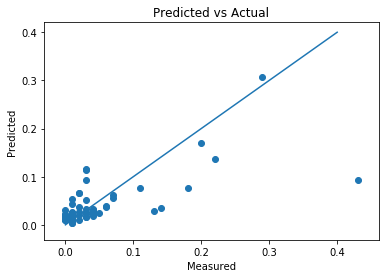

In [55]:
plt.scatter(y_test, extra_pred)
plt.plot(np.linspace(0, .4, 1000),np.linspace(0, .4, 1000))
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

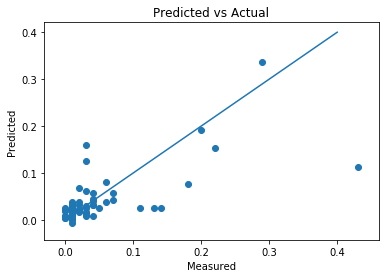

In [56]:
plt.scatter(y_test, xgb_pred)
plt.plot(np.linspace(0, .4, 1000),np.linspace(0, .4, 1000))
plt.xlabel('Measured')
plt.ylabel('Predicted')
plt.title('Predicted vs Actual')
plt.show()

### Create confidence interval for best model

In [57]:
import forestci as fci
# Calculate the variance:
rf_pred_unbiased = fci.random_forest_error(rf, X_train, X_test)

Failed to import duecredit due to No module named 'duecredit'


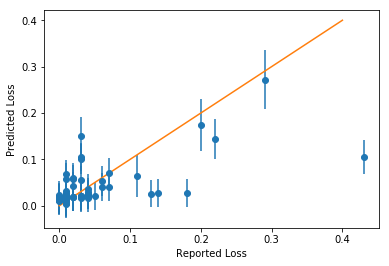

In [58]:
plt.errorbar(y_test, rf_pred, yerr=np.sqrt(rf_pred_unbiased), fmt='o')
plt.plot(np.linspace(0, .4, 1000),np.linspace(0, .4, 1000))
plt.xlabel('Reported Loss')
plt.ylabel('Predicted Loss')
plt.show()

## Create Loss Categories and Make Classification Experiment

As our margin of error seems to be somewhat large we can try to rephrase our problem. Instead of forecasting the exact percentage we can forecast a category as follws:
- Low risk (0%-5% loss)
- Medium risk (5%-10% loss)
- High risk (>10% loss)

In [59]:
df['loss_cat'] = pd.cut(df['livestock_loss'], [0, 0.05, 0.10, 100], right=False, include_lowest=True, labels=['low','medium','high'])

In [60]:
df.head()

,temperature_anomaly_2,livestock_loss_2,snowfall_anomaly_2,temperature_anomaly_1,livestock_loss_1,snowfall_anomaly_1,biomass_anomaly_1_3,zootechnical_1_3,pasture_use_anomaly_1_3,biomass_anomaly_1_2,...,year,temperature_anomaly,livestock_loss,index,pasture_use,biomass,mortality,fecundity,snowfall_anomaly,loss_cat
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1999,2.75,0.01,1.69,0.11,2.96,0,0,-3.80,low
1,NaN,NaN,NaN,2.75,0.01,-3.80,NaN,NaN,NaN,NaN,...,2000,-0.39,0.06,1.94,0.12,2.44,0,0,4.57,medium
2,2.75,0.01,-3.80,-0.39,0.06,4.57,NaN,NaN,NaN,0.05,...,2001,-1.62,0.24,2.63,0.10,2.20,1,1,8.10,high
3,-0.39,0.06,4.57,-1.62,0.24,8.10,0.05,0.0,0.04,-0.13,...,2002,0.86,0.04,2.81,0.17,1.22,0,0,5.44,low
4,-1.62,0.24,8.10,0.86,0.04,5.44,-0.13,0.0,0.18,-0.22,...,2003,-0.10,0.07,1.15,0.08,2.61,0,0,9.70,medium


In [61]:
train = df.drop(columns=[
    'aimag','year','fecundity','mortality',
    'biomass','pasture_use','index', 'livestock_loss'], axis=1)

In [62]:
train.head()

,temperature_anomaly_2,livestock_loss_2,snowfall_anomaly_2,temperature_anomaly_1,livestock_loss_1,snowfall_anomaly_1,biomass_anomaly_1_3,zootechnical_1_3,pasture_use_anomaly_1_3,biomass_anomaly_1_2,zootechnical_1_2,pasture_use_anomaly_1_2,biomass_anomaly_1,zootechnical_1,pasture_use_anomaly_1,temperature_anomaly,snowfall_anomaly,loss_cat
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.75,-3.80,low
1,NaN,NaN,NaN,2.75,0.01,-3.80,NaN,NaN,NaN,NaN,NaN,NaN,0.05,0.0,0.04,-0.39,4.57,medium
2,2.75,0.01,-3.80,-0.39,0.06,4.57,NaN,NaN,NaN,0.05,0.0,0.04,-0.13,0.0,0.18,-1.62,8.10,high
3,-0.39,0.06,4.57,-1.62,0.24,8.10,0.05,0.0,0.04,-0.13,0.0,0.18,-0.22,2.0,-0.02,0.86,5.44,low
4,-1.62,0.24,8.10,0.86,0.04,5.44,-0.13,0.0,0.18,-0.22,2.0,-0.02,-0.57,0.0,0.63,-0.10,9.70,medium


We will drop the NaN values as this row will not be able to be used in the training algorithm.

In [63]:
train = train.dropna(axis=0).reset_index(drop=True)

In [64]:
train.head()

,temperature_anomaly_2,livestock_loss_2,snowfall_anomaly_2,temperature_anomaly_1,livestock_loss_1,snowfall_anomaly_1,biomass_anomaly_1_3,zootechnical_1_3,pasture_use_anomaly_1_3,biomass_anomaly_1_2,zootechnical_1_2,pasture_use_anomaly_1_2,biomass_anomaly_1,zootechnical_1,pasture_use_anomaly_1,temperature_anomaly,snowfall_anomaly,loss_cat
0,-0.39,0.06,4.57,-1.62,0.24,8.10,0.05,0.0,0.04,-0.13,0.0,0.18,-0.22,2.0,-0.02,0.86,5.44,low
1,-1.62,0.24,8.10,0.86,0.04,5.44,-0.13,0.0,0.18,-0.22,2.0,-0.02,-0.57,0.0,0.63,-0.10,9.70,medium
2,0.86,0.04,5.44,-0.10,0.07,9.70,-0.22,2.0,-0.02,-0.57,0.0,0.63,-0.07,0.0,-0.25,0.54,2.30,low
3,-0.10,0.07,9.70,0.54,0.01,2.30,-0.57,0.0,0.63,-0.07,0.0,-0.25,-0.14,0.0,-0.17,-2.70,-2.33,low
4,0.54,0.01,2.30,-2.70,0.01,-2.33,-0.07,0.0,-0.25,-0.14,0.0,-0.17,-0.20,0.0,-0.03,-0.17,-3.23,low


In [65]:
train.shape

(260, 18)

In [66]:
y = train['loss_cat']
X = train.drop(columns=['loss_cat'],axis=1)

In [67]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

### Run Classification Algorithm

In [68]:
from sklearn.preprocessing import OrdinalEncoder
enc = OrdinalEncoder()
enc.fit(train[['loss_cat']])

OrdinalEncoder(categories='auto', dtype=<class 'numpy.float64'>)

In [69]:
y = enc.transform(train[['loss_cat']])

In [77]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier(random_state=42, n_estimators=100)
rf.fit(X_train,y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=None,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [71]:
#from sklearn.model_selection import cross_val_score, cross_val_predict
#rf_score = cross_val_score(rf, X_train, y, cv=5)
#print("Accuracy: %0.2f (+/- %0.2f)" % (rf_score.mean(), rf_score.std() * 2))

C:\Users\rober\Anaconda3\envs\standard\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\rober\Anaconda3\envs\standard\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\rober\Anaconda3\envs\standard\lib\site-packages\sklearn\model_selection\_validation.py:528: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\rober\Anaconda3\envs\standard\lib\site-packages\sklearn\model_selection\_valida

Accuracy: 0.84 (+/- 0.03)


In [72]:
rf_prob = rf.predict_proba(X)
rf_pred = cross_val_predict(rf,X,y,cv=5)

C:\Users\rober\Anaconda3\envs\standard\lib\site-packages\sklearn\model_selection\_validation.py:850: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\rober\Anaconda3\envs\standard\lib\site-packages\sklearn\model_selection\_validation.py:850: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\rober\Anaconda3\envs\standard\lib\site-packages\sklearn\model_selection\_validation.py:850: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  estimator.fit(X_train, y_train, **fit_params)
C:\Users\rober\Anaconda3\envs\standard\lib\site-packages\sklearn\model_selection\_valida

In [73]:
pred = X

In [74]:
pred['prob_med'] = rf_prob[:,0]
pred['prob_low'] = rf_prob[:,1]
pred['prob_high'] = rf_prob[:,2]
pred['loss_cat'] = y
pred['pred'] = rf_pred

In this situation where I trained the whole dataset our confusion matrix looks perfect. However we know from our cross validation score that our accuracy % is 84%.

[[ 11  18   1]
 [  2 208   0]
 [  2  18   0]]


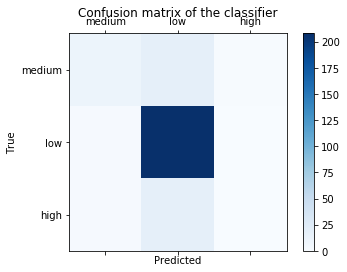

In [76]:
from sklearn.metrics import confusion_matrix
labels = ['medium','low','high']
cm = confusion_matrix(y, rf_pred.reshape(-1,1))
print(cm)
fig = plt.figure()
ax = fig.add_subplot(111)
cax = ax.matshow(cm, cmap=plt.cm.Blues, interpolation='nearest')
plt.title('Confusion matrix of the classifier')
fig.colorbar(cax)
ax.set_xticklabels([''] + labels)
ax.set_yticklabels([''] + labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.show()

Next Steps:
- Rebalance classes
- After classes are rebalanced do a split. In this way we will get an equal numer of each occurence to train on. 
- Score on testing set